# Unsupervised Learning & Dimensionality Reduction Using Diabetes Dataset

In 2014, some researchers published an article called "Impact of c1HbA Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records." The dataset used in this notebook is a subset of the dataset used in the article containing 50 columns. The columns are as follows:
- encounter_id: Unique identifier of an encounter
- patient_nbr: Unique identifier of a patient
- race: race of each patient including Asian, African American, ...
- gender: gender of each patient
- age: age of each patient grouped in 10-year intervals: (0, 10), (10, 20), ..., (90, 100)
- weight: weight in pounds
- admission_type_id: Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available
- discharge_disposition_id: Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available
- admission_source_id: Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
- time_in_hospital: Integer number of days between admission and discharge
- payer_code: Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay
- medical_specialty: Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon
- num_lab_procedures: Number of lab tests performed during the encounter
- num_procedures: Number of procedures (other than lab tests) performed during the encounter
- num_medications: Number of distinct generic names administered during the encounter
- number_outpatient: Number of outpatient visits of the patient in the year preceding the encounter
- number_emergency: Number of emergency visits of the patient in the year preceding the encounter
- number_inpatient: Number of inpatient visits of the patient in the year preceding the encounter
- diag_1: The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
- diag_2: Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
- diag_3: Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
- number_diagnoses: Number of diagnoses entered to the system
- max_glu_serum: Indicates the range of the result or if the test was not taken. Values: "None", ">200", "normal", ">300"
- A1Cresult: Indicates the range of the result or if the test was not taken. Values: "None", ">7", "normal", ">8"
- change: Indicates if there was a change in diabetic medications (either dosage or generic name). Values: "change" and "no change"
- diabetesMed: Indicates if there was any diabetic medication prescribed. Values: "yes" and "no"
- readmitted: Days to inpatient readmission. Values: "<30" if the patient was readmitted in less than 30 days, ">30" if the patient was readmitted in more than 30 days, and "No" if the patient was not readmitted

Import the necessary libraries and load the dataset.

In [87]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import io
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [88]:
DATA_FILE_PATH = 'dataset_diabetes/diabetic_data.csv'
MAPPING_FILE_PATH = 'dataset_diabetes/IDs_mapping.csv'

In [89]:
diabetes_df = pd.read_csv(DATA_FILE_PATH)

## Preprocessing

In [90]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

### Mapping the Labels

In this part we read the mapping file and map the labels to integers. We remove the first space in values if exists.

In [91]:
with open(MAPPING_FILE_PATH, 'r') as file:
    content = file.read()
sections = content.strip().split('\n,\n')

mappings = {}
for section in sections:
    section_df = pd.read_csv(io.StringIO(section))
    column_name = section_df.columns[0]
    mappings[column_name] = dict(zip(section_df[column_name], section_df['description']))

admission_type_mapping = mappings['admission_type_id']
discharge_disposition_mapping = mappings['discharge_disposition_id']
admission_source_mapping = mappings['admission_source_id']

cleaned_admission_type_mapping = {k: v.strip() if isinstance(v, str) else v for k, v in admission_type_mapping.items()}
cleaned_discharge_disposition_mapping = {k: v.strip() if isinstance(v, str) else v for k, v in discharge_disposition_mapping.items()}
cleaned_admission_source_mapping = {k: v.strip() if isinstance(v, str) else v for k, v in admission_source_mapping.items()}

diabetes_df['admission_type_id'] = diabetes_df['admission_type_id'].map(cleaned_admission_type_mapping)
diabetes_df['discharge_disposition_id'] = diabetes_df['discharge_disposition_id'].map(cleaned_discharge_disposition_mapping)
diabetes_df['admission_source_id'] = diabetes_df['admission_source_id'].map(cleaned_admission_source_mapping)


### Checking for Duplicate Rows

We check for duplicate rows and remove them. In this dataset, there are no duplicate rows.

In [92]:
print('Number of rows before dropping duplicates:', diabetes_df.shape[0])
diabetes_df.drop_duplicates(inplace=True)
print('Number of rows after dropping duplicates:', diabetes_df.shape[0])


Number of rows before dropping duplicates: 101766
Number of rows after dropping duplicates: 101766


### Handling Missing Values

We replace `Not Mapped`, `Not Available`, `Unknown/Invalid`, `?`, and `None` values with `np.nan` in order to consider them as missing values. We also drop the columns with more than 50% missing values.

In [93]:
diabetes_df.replace('Not Available', np.nan, inplace=True)
diabetes_df.replace('Not Mapped', np.nan, inplace=True)
diabetes_df.replace('?', np.nan, inplace=True)
diabetes_df.replace('Unknown/Invalid', np.nan, inplace=True)
diabetes_df.replace('None', np.nan, inplace=True)

nan_values = diabetes_df.isnull().sum()
print("Number of NaN values in each column:")
print(nan_values)

Number of NaN values in each column:
encounter_id                    0
patient_nbr                     0
race                         2273
gender                          3
age                             0
weight                      98569
admission_type_id           10396
discharge_disposition_id     4680
admission_source_id          7067
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride

We drop the columns that more than 30% of their values are NaN.

In [94]:
missing_values_threshold = diabetes_df.shape[0] * 0.7
diabetes_df.dropna(thresh=missing_values_threshold, axis=1, inplace=True)

The most frequent value in each column and its frequency is calculated. As we can see most of them has a high frequency so we use them to fill the missing values.

In [95]:
cols_with_Nulls = diabetes_df.columns[diabetes_df.isnull().any()].tolist()
print("Columns with null values:")

for col in cols_with_Nulls:
    value_counts = diabetes_df[col].value_counts()
    top_two_values = value_counts.head(1)
    print(f"Most frequent value in column {col}: {top_two_values}")
    
for col in cols_with_Nulls:
    diabetes_df[col].fillna(diabetes_df[col].value_counts().idxmax(), inplace=True)

Columns with null values:
Most frequent value in column race: Caucasian    76099
Name: race, dtype: int64
Most frequent value in column gender: Female    54708
Name: gender, dtype: int64
Most frequent value in column admission_type_id: Emergency    53990
Name: admission_type_id, dtype: int64
Most frequent value in column discharge_disposition_id: Discharged to home    60234
Name: discharge_disposition_id, dtype: int64
Most frequent value in column admission_source_id: Emergency Room    57494
Name: admission_source_id, dtype: int64
Most frequent value in column diag_1: 428    6862
Name: diag_1, dtype: int64
Most frequent value in column diag_2: 276    6752
Name: diag_2, dtype: int64
Most frequent value in column diag_3: 250    11555
Name: diag_3, dtype: int64


In [96]:
categorical = diabetes_df.select_dtypes(include=['object'])
categorical_cols = categorical.columns.drop('readmitted')
numerical_cols = diabetes_df.select_dtypes(include=['int64', 'float64']).columns

### Group `diag_1`, `diag_2`, and `diag_3` Values

We used the first three digits of the ICD9 codes to group the values. 

In [97]:
ranges = [
    (1, 140, 1),
    (140, 240, 2),
    (240, 280, 3),
    (280, 290, 4),
    (290, 320, 5),
    (320, 390, 6),
    (390, 460, 7),
    (460, 520, 8),
    (520, 580, 9),
    (580, 630, 10),
    (630, 680, 11),
    (680, 710, 12),
    (710, 740, 13),
    (740, 760, 14),
    (760, 780, 15),
    (780, 800, 16),
    (800, 1000, 17),
]

def group_by_range(value):
    try:
        value = float(value)
        for lower, upper, group in ranges:
            if lower <= value < upper:
                return group
    except ValueError:
        return 18

diabetes_df['diag_1'] = diabetes_df['diag_1'].apply(group_by_range)
diabetes_df['diag_2'] = diabetes_df['diag_2'].apply(group_by_range)
diabetes_df['diag_3'] = diabetes_df['diag_3'].apply(group_by_range)

### Handling Outliers

In this part we calculate the z-score of each column and replace the values that their z-score is more than 3 or less than -3 with the median of the column. We used replacing instead of removing the rows because the dataset has many columns and removing the rows may cause loss of information.

In [98]:
def replace_outliers_with_median(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        z_scores = (df[column] - df[column].mean()) / df[column].std()
        outliers = (z_scores > 3) | (z_scores < -3)
        median = df[column].median()
        df.loc[outliers, column] = median
    return df

diabetes_df = replace_outliers_with_median(diabetes_df)

### Encoding Categorical Columns

In this part we count the number of unique values in each categorical column and drop the columns with only one unique value.

#### Medication Columns

We have some medication features that have 4 unique values : `No`, `Steady`, `Up`, and `Down`. We first convert them to numerical values using label encoding because the values are ordinal. Then we display the frequency of each value.

In [99]:
medication_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
                          'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
                          'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
                          'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 
                          'insulin', 'glyburide-metformin', 'glipizide-metformin', 
                          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
                          'metformin-pioglitazone']
medication_features_mapping = {k: {'No': 0, 'Down': 1, 'Steady': 2, 'Up': 3} for k in medication_features}

for feature in medication_features:
    diabetes_df[feature] = diabetes_df[feature].map(medication_features_mapping[feature])

for feature in medication_features:
    print(f"Frequency of values in {feature} column:")
    print(diabetes_df[feature].value_counts())

Frequency of values in metformin column:
0    81778
2    18346
3     1067
1      575
Name: metformin, dtype: int64
Frequency of values in repaglinide column:
0    100227
2      1384
3       110
1        45
Name: repaglinide, dtype: int64
Frequency of values in nateglinide column:
0    101063
2       668
3        24
1        11
Name: nateglinide, dtype: int64
Frequency of values in chlorpropamide column:
0    101680
2        79
3         6
1         1
Name: chlorpropamide, dtype: int64
Frequency of values in glimepiride column:
0    96575
2     4670
3      327
1      194
Name: glimepiride, dtype: int64
Frequency of values in acetohexamide column:
0    101765
2         1
Name: acetohexamide, dtype: int64
Frequency of values in glipizide column:
0    89080
2    11356
3      770
1      560
Name: glipizide, dtype: int64
Frequency of values in glyburide column:
0    91116
2     9274
3      812
1      564
Name: glyburide, dtype: int64
Frequency of values in tolbutamide column:
0    101743
2  

As we can see, In columns `chlorpropamide`, `glyburide-metformin`, and `acarbose` the value for `Down` , `Up` and `Steady` are not frequent comparing to `No` value so we use binary values for them: 0 for no description and 1 for any description.  
Also in columns `acetohexamide`, `tolbutamide`, `miglitol`, `tolazamide`, `glipizide-metformin`, `glimepiride-pioglitazone`, `metformin-rosiglitazone`, and `metformin-pioglitazone` the value for columns that are not `No` are so little that we can drop the columns.

In [100]:
replacement_mapping = {1: 1, 2: 1, 3: 1}
diabetes_df[['chlorpropamide', 'acarbose', 'glyburide-metformin']] = diabetes_df[['chlorpropamide', 'acarbose', 'glyburide-metformin']].replace(replacement_mapping)

cols_with_not_frequnet_values = ['acetohexamide', 'tolbutamide', 'troglitazone', 'miglitol', 'tolazamide', 'glipizide-metformin', 
                                 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
diabetes_df.drop(cols_with_not_frequnet_values, axis=1, inplace=True)

#### Age column

In [101]:
age_mapping = { '[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4, '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9 }
diabetes_df['age'] = diabetes_df['age'].map(age_mapping)

In this part we replace the values that their frequency is less than 50 with `'other'` in order to reduce the number of unique values. We also remove the columns that has less than 3 unique values and one of them has a frequency of less than 50.

In [102]:
categorical_columns = diabetes_df.select_dtypes(include='object').columns
for col in categorical_columns:
    value_counts = diabetes_df[col].value_counts()
    values_to_label = value_counts[value_counts < 0.0005 * diabetes_df[col].shape[0]].index
    diabetes_df[col] = diabetes_df[col].apply(lambda x: 'other' if x in values_to_label else x)


In [103]:
categorical_columns = diabetes_df.select_dtypes(include='object').columns
print('Number of unique values in each column:')
for column in categorical_columns:
    print(f"{column}: {diabetes_df[column].nunique()}")
    
unique_value_columns = diabetes_df.columns[diabetes_df.nunique() == 1]
diabetes_df.drop(unique_value_columns, axis=1, inplace=True)

Number of unique values in each column:
race: 5
gender: 2
admission_type_id: 4
discharge_disposition_id: 16
admission_source_id: 8
change: 2
diabetesMed: 2
readmitted: 3


In [104]:
X_train = diabetes_df.drop(columns=['readmitted'])
y_train = diabetes_df['readmitted']

#### Convert Categorical Columns to Numerical (One-Hot Encoding or Label Encoding) 

In this part we convert the categorical columns to numerical using one-hot encoding because this type of encoding does not assume that the features are ordinal. In our case the remaining categorical features are nor ordinal so we use one-hot encoding.

In [105]:

# categorical_columns = X_train.select_dtypes(include='object').columns
# label_encode_columns = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
# one_hot_columns = []
# for col in categorical_columns:
#     if col not in label_encode_columns:
#         one_hot_columns.append(col)

# one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
# one_hot_encoded = one_hot_encoder.fit_transform(X_train[one_hot_columns])

# label_encoded_df = diabetes_df[categorical_columns].apply(LabelEncoder().fit_transform)

# X_train.drop(columns=one_hot_columns + label_encode_columns, inplace=True)
# X_train = pd.concat([X_train, label_encoded_df], axis=1)
# one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_columns))

# label_encoder = LabelEncoder()
# for column in categorical_columns:
#     X_train[column] = label_encoder.fit_transform(X_train[column])

In [106]:
def encode_onehot(df, column):
    onehot = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, onehot], axis=1)
    df = df.drop(column, axis=1)
    return df

In [107]:

categorical_columns = X_train.select_dtypes(include='object').columns

for column in categorical_columns:
    X_train = encode_onehot(X_train, column)



In [108]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 65 columns):
 #   Column                                                                                                                              Non-Null Count   Dtype
---  ------                                                                                                                              --------------   -----
 0   encounter_id                                                                                                                        101766 non-null  int64
 1   patient_nbr                                                                                                                         101766 non-null  int64
 2   age                                                                                                                                 101766 non-null  int64
 3   time_in_hospital                                                                    

The columns `encounter_id` and `patient_nbr` are dropped because they are either unique for each row or does not effect the result and do not provide any information.

In [109]:
X_train.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)

### Standardizing the Data

We standardize the data using `StandardScaler` in order to have zero mean and unit variance. We should standardize the data before applying PCA because PCA is sensitive to the scale of the data. The key point in standardization is that we only standardize the numerical features.

In [110]:
scaler = StandardScaler()
# X_train_standardized= scaler.fit_transform(X_train)
X_train_standardized = X_train.copy()
# apply scaler for different columns
for col in X_train.columns:
    if col in numerical_cols:
        X_train_standardized[col] = scaler.fit_transform(X_train[col].values.reshape(-1, 1))
        
X_train_standardized.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,...,admission_source_id_HMO Referral,admission_source_id_Physician Referral,admission_source_id_Transfer from a Skilled Nursing Facility (SNF),admission_source_id_Transfer from a hospital,admission_source_id_Transfer from another health care facility,admission_source_id_other,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,0,-1.167569,-0.105366,-0.785398,-2.038899,-0.360564,-0.306317,-0.567598,3,3,...,0,1,0,0,0,0,0,1,1,0
1,1,-0.458575,0.811774,-0.785398,0.339504,-0.360564,-0.306317,-0.567598,3,3,...,0,0,0,0,0,0,1,0,0,1
2,2,-0.813072,-1.633932,2.145781,-0.360026,2.434357,-0.306317,0.556749,11,3,...,0,0,0,0,0,0,0,1,0,1
3,3,-0.813072,0.047490,-0.199162,0.059692,-0.360564,-0.306317,-0.567598,1,3,...,0,0,0,0,0,0,1,0,0,1
4,4,-1.167569,0.404156,-0.785398,-1.059557,-0.360564,-0.306317,-0.567598,2,2,...,0,0,0,0,0,0,1,0,0,1


## Dimensionality Reduction

### Principal Component Analysis (PCA)

PCA is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.  
We set the `n_components` parameter to 0.9 to keep the minimum number of principal components that explain 90% of the variance. We also set the `random_state` to 42 for reproducibility. After fitting the PCA model to the data, we transform the data into the new space.  
`pca.components_[0].argsort()[::-1]` returns the indices of the features sorted in descending order based on their loadings (or weights) in the first principal component. `X_train.columns[...]` uses these indices to get the names of the columns in the sorted order.

In [111]:
pca = PCA(n_components=0.5, random_state=42)
X_reduced = pca.fit_transform(X_train_standardized)
pca.explained_variance_ratio_
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i}' for i in range(1, X_reduced.shape[1] + 1)])

selected_columns = X_train.columns[pca.components_[0].argsort()[::-1]]
for col in selected_columns:
    print(f"{col}: {pca.components_[0][X_train.columns.get_loc(col)]}")

diag_1: 0.6886554151876098
diag_3: 0.6505681633464075
diag_2: 0.31649666337231946
number_diagnoses: 0.02759036564509509
age: 0.027131298382077486
num_medications: 0.011180821594673998
discharge_disposition_id_Discharged/transferred to SNF: 0.005192554149713611
number_inpatient: 0.004557517792747963
admission_type_id_Elective: 0.004525778900268314
number_outpatient: 0.004482962988633668
metformin: 0.003840952310147248
num_procedures: 0.0035184624931038355
discharge_disposition_id_Discharged/transferred to home with home health service: 0.0030718095702207317
race_Caucasian: 0.0029573815117542534
change_No: 0.0025482681262763447
pioglitazone: 0.0024192050124436488
diabetesMed_No: 0.0022011686396342972
gender_Female: 0.001969322279424549
admission_source_id_Physician Referral: 0.0018921381520540063
discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital .: 0.0018808141601520877
glyburide: 0.0017382467897452457
admission_source_id_Transfer fr

In [112]:
display(X_reduced_df)

,PC1,PC2
0,-8.163628,0.411659
1,-8.165266,0.526503
2,7.186028,5.161214
3,-6.908716,4.681835
4,-9.144380,1.017464
...,...,...
101761,-4.725034,3.469927
101762,4.670688,5.268190
101763,-5.777161,4.109306
101764,11.141742,0.458503


As we can see, we have two principal components that explain 50% of variation. These two components are a linear combination of the original features which are listed below.

The selected features are as follows:

In [113]:
n_selected_components = pca.n_components_
original_feature_names = X_train.columns
selected_feature_indices = pca.components_[:n_selected_components].argsort()[-1:].flatten()
selected_feature_names = [original_feature_names[i] for i in selected_feature_indices]

print('Selected features:')
for feature in selected_feature_names:
    print(feature)


Selected features:
diag_1
metformin
gender_Female
age
change_No
pioglitazone
glyburide
admission_type_id_Elective
discharge_disposition_id_Discharged to home
rosiglitazone
diabetesMed_No
glipizide
admission_source_id_Physician Referral
admission_source_id_Transfer from a hospital
discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital .
race_Caucasian
discharge_disposition_id_Discharged/transferred to another type of inpatient care institution
admission_source_id_Transfer from another health care facility
glimepiride
race_Hispanic
glyburide-metformin
race_Other
chlorpropamide
admission_source_id_HMO Referral
race_Asian
admission_type_id_other
admission_source_id_other
discharge_disposition_id_Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
discharge_disposition_id_Discharged/transferred within this institution to Medicare approved swing bed
admission_source_id_Clinic Referral
disc

## Unsupervised Learning

Unsupervised learning is a type of machine learning that looks for previously undetected patterns in a data set with no pre-existing labels and with a minimum of human supervision. In contrast to supervised learning that usually makes use of human-labeled data, unsupervised learning, also known as self-organization allows for modeling of probability densities over inputs.

### K-Means Clustering

#### Silhouette Score

Silhouette score is the mean silhouette coefficient for all instances. An instance's silhouette coefficient is equal to $\frac{(b - a)}{max(a, b)}$, where a is the mean distance to the other instances in the same cluster and b is the mean distance to the instances in the next closest cluster. The silhouette score ranges from -1 (worst) to 1 (best). A coefficient close to +1 indicates that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 indicates that it is close to a cluster boundary, and a coefficient close to -1 indicates that the instance may have been assigned to the wrong cluster.

In [114]:
from joblib import Parallel, delayed
best_n_clusters = 1
best_silhouette_score = -1
wcss = []
silhouette_scores = []
range_n_clusters = range(2, 8)

def compute_kmeans_silhouette(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    return (n_clusters, kmeans.inertia_, silhouette_avg)

results = Parallel(n_jobs=-1)(delayed(compute_kmeans_silhouette)(n_clusters, X_reduced) for n_clusters in range_n_clusters)

for n_clusters, inertia, silhouette_avg in results:
    print(f"Number of clusters: {n_clusters}, WCSS: {inertia}, Silhouette score: {silhouette_avg}")
    wcss.append(inertia)
    silhouette_scores.append(silhouette_avg)
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"Best number of clusters for KMeans: {best_n_clusters}")

kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_reduced)

Number of clusters: 2, WCSS: 2586703.5293032485, Silhouette score: 0.4389438520707982
Number of clusters: 3, WCSS: 1550742.0253396686, Silhouette score: 0.47771995725982375
Number of clusters: 4, WCSS: 1210736.120273435, Silhouette score: 0.4025614436837104
Number of clusters: 5, WCSS: 894633.9339564709, Silhouette score: 0.4258228907304876
Number of clusters: 6, WCSS: 672284.0306315155, Silhouette score: 0.4699326052851671
Number of clusters: 7, WCSS: 579205.8736867395, Silhouette score: 0.4764809500946443
Best number of clusters for KMeans: 3


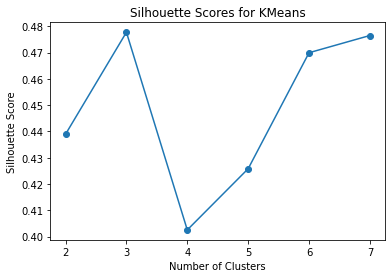

In [53]:
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.xticks(range_n_clusters)
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for KMeans')
plt.show()

As we can see the silhouette score is around 0 which is not a good score. This may be due to the high dimensionality of the data. We reduce the dimensionality of the data using PCA and applying 0.5 for the number of components percentage.

#### Elbow Method Plot

The elbow method is a heuristic used to determine the optimal number of clusters in a dataset. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. The explained variation is the percentage of variance that each of the principal components explains. WCSS stands for Within-Cluster Sum of Squares which is the sum of squares of the distances of each data point in all clusters to their respective centroids. The idea is to minimize WCSS.

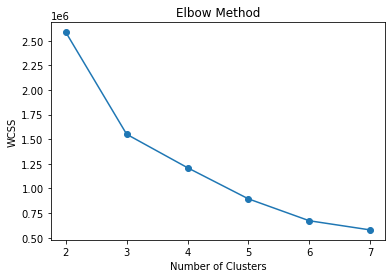

In [54]:
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range_n_clusters)
plt.show()

As we can see from the elbow method plot, the optimal number of clusters seems to be 3.

### DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups together points that are closely packed. It is also able to identify points that are in low-density regions as outliers. The algorithm works by defining a minimum number of points (min_samples) and a maximum distance from a point for another point to be considered its neighbor (eps). Points that have at least min_samples neighbors within a distance of eps are considered as core points and form a cluster. Points that do not have enough neighbors but are close to a core point are considered as border points and are part of the same cluster as the core point. Points that are neither core nor border points are considered as noise.

In [115]:
eps_values = [0.3, 0.5, 1.0]
min_samples_values = [2, 3, 5, 7]

silhouette_scores = np.zeros((len(eps_values), len(min_samples_values)))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_reduced)
        if len(np.unique(dbscan_labels)) > 1:
            silhouette_scores[i, j] = silhouette_score(X_reduced, dbscan_labels)
            print(f"eps: {eps}, min_samples: {min_samples}, Silhouette score: {silhouette_scores[i, j]}")
        else:
            silhouette_scores[i, j] = -1

best_silhouette_score = np.max(silhouette_scores)
best_eps_index = np.argmax(np.max(silhouette_scores, axis=1))
best_min_samples_index = np.argmax(silhouette_scores[best_eps_index])
best_eps = eps_values[best_eps_index]
best_min_samples = min_samples_values[best_min_samples_index]

print(f"Best silhouette score for DBSCAN: {best_silhouette_score:.2f}")
print(f"Optimal eps for DBSCAN: {best_eps:.2f}")
print(f"Optimal min_samples for DBSCAN: {best_min_samples}")

eps: 0.3, min_samples: 2, Silhouette score: -0.4969348882171014
eps: 0.3, min_samples: 3, Silhouette score: -0.45816284117045575
eps: 0.3, min_samples: 5, Silhouette score: -0.38952541594603646
eps: 0.3, min_samples: 7, Silhouette score: -0.3552647035441286
eps: 0.5, min_samples: 2, Silhouette score: -0.20348322848527964
eps: 0.5, min_samples: 3, Silhouette score: -0.19235800664743222
eps: 0.5, min_samples: 5, Silhouette score: -0.15969400288255078
eps: 0.5, min_samples: 7, Silhouette score: -0.07349656992388381
Best silhouette score for DBSCAN: -0.07
Optimal eps for DBSCAN: 0.50
Optimal min_samples for DBSCAN: 7


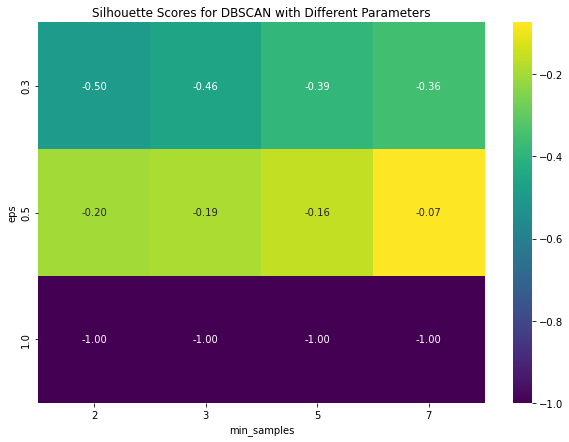

In [116]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(silhouette_scores, xticklabels=min_samples_values, yticklabels=eps_values, annot=True, fmt=".2f", cmap="viridis")
plt.title("Silhouette Scores for DBSCAN with Different Parameters")
plt.xlabel("min_samples")
plt.ylabel("eps")
plt.show()

As we can see from the above plot the optimal value for eps seems to be 0.3 and the optimal value for min_samples seems to be 5 which results in a silhouette score of -0.13. As we can see the silhouette score is negative which is not a good score and k-mean model works better than DBSCAN for this dataset.

## Questions

**Question 1:** `What preprocessing steps did you perform on the dataset? Provide clear reasons for each decision made.`  
- Mapping the Labels: We map the description of the admission_type_id, discharge_disposition_id, and admission_source_id to the corresponding integer values in order to be able to handle missing values later.
- Handling Duplicate Rows: We check for duplicate rows in order to remove them. In this dataset, there are no duplicate rows.
- Handling Missing Values: We replace `Not Mapped`, `Not Available`, `Unknown/Invalid`, `?`, and `None` values with `np.nan` in order to consider them as missing values. We also drop the columns with more than 30% missing values. We fill the other missing values with the most frequent value in each column because most of them have a high frequency. Handling missing values is necessary to ensure the algorithms can process the data without errors also if missing values are not handled properly, the model may learn incorrect patterns, leading to poor generalization and inaccurate predictions.
- Encoding Categorical Columns: We count the number of unique values in each categorical column and drop the columns with only one unique value. We encode the categorical columns which were ordinal containing medication features and age column using label encoding. We also convert the remaining categorical columns to numerical using one-hot encoding. Encoding categorical columns is necessary because most machine learning algorithms require numerical input and output variables. Also, the model may interpret the ordinal values as having some kind of order or hierarchy.
- Handling Outliers: We calculate the z-score of each column and replace the values that their z-score is more than 3 or less than -3 with the median of the column. We use replacing instead of removing the rows because the dataset has many columns and removing the rows may cause loss of information. Handling outliers is necessary because outliers can skew the results and make the model less accurate.
- standardizing the data: We standardize the data using StandardScaler to ensure that each feature contributes equally to the distance computations. Standardizing the data is necessary because many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and close to normally distributed. The key point in standardization is that we only standardize the numerical features.

**Question 2:** `What portion of the dataset did you retain during dimensionality reduction, and which variables were retained? Could you elaborate on the rationale behind this decision?`  
During dimensionality reduction, the goal is to reduce the number of features or variables in a dataset while retaining as much information as possible. In this case, we used PCA to reduce the dimensionality of the dataset. We set the `n_components` parameter to 0.9 to keep the minimum number of principal components that explain 90% of the variance. The rationale behind this decision is to reduce the dimensionality of the dataset while retaining most of the variance in the data. The retained variables are the principal components that explain the most variance in the data. In this case, we retained variables after dimensionality reduction which are shown in the previous code cell.

**Question 3:** `How can we determine the optimal number of clusters in K-Means?`   
There are several methods to determine the optimal number of clusters:
- Elbow Method: The Elbow Method is a heuristic method used to estimate the optimal number of clusters in a dataset. It works by plotting the within-cluster sum of squares (WCSS) against the number of clusters. The optimal number of clusters is the point where the rate of decrease in WCSS slows down, forming an "elbow" in the plot.
- Silhouette Score: The Silhouette Score is a metric used to evaluate the quality of clusters created by a clustering algorithm. It measures how similar an instance is to its own cluster compared to other clusters. The Silhouette Score ranges from -1 to 1, where a higher score indicates better-defined clusters. The optimal number of clusters is the one that maximizes the Silhouette Score. We used this method to determine the optimal number of clusters in K-Means in this notebook.
- Gap Statistics: Gap Statistics is another method used to estimate the optimal number of clusters. It compares the within-cluster variation for different numbers of clusters with their expected values under null reference distribution of the data. The optimal number of clusters is the one that maximizes the gap statistic.
- Davies-Bouldin Index: The Davies-Bouldin Index evaluates the average similarity ratio of each cluster with the cluster that is most similar to it. Lower values indicate better clustering.

**Question 4:** `How can we determine the optimal epsilon value and minPts in DBSCAN?`  
Determining the optimal epsilon value and minPts in DBSCAN can be done using the following methods:
- Silhouette Score: The Silhouette Score can be used to evaluate the quality of clusters created by DBSCAN. It measures how similar an instance is to its own cluster compared to other clusters. The optimal epsilon value and minPts are the ones that maximize the Silhouette Score.
- K-Distance Graph: Compute the distance to the k-nearest neighbor for each point and plot them sorted in ascending order. The optimal eps value often corresponds to the "knee" or elbow point in the graph.
- Reachability Plot: Plot the points in the dataset sorted by their reachability distance. The point where the reachability plot exhibits a significant increase indicates a suitable eps value. The reachability score is the distance between a point and its k-nearest neighbor.

**Question 5:** `When would you recommend using K-Means, and when would you suggest using DBSCAN instead?`  
We use K-Means when: 
- The dataset is large and clusters are spherical and similar in size.
- The number of clusters is known and fixed.
- The speed and scalability are important.
Customer segmentation in marketing where you expect roughly spherical clusters representing different customer types is a good example for using K-Means. 

We use DBSCAN when:
- The clusters are irregular in shape and vary in density.
- The number of clusters is not known.
- The data is not too high-dimensional.
Identifying geographic regions with different population densities or finding clusters in spatial data with noise, like star formation in astronomy is a good example for using DBSCAN.